# YOLO models from ultralytics

This notebook allows you to train and test YOLO models from ultralytics.

Here is a list of available models : https://hub.ultralytics.com/models


In [ ]:
!pip install ultralytics
!pip install roboflow

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="Z4mFtu232oWID8Vtcntw")
project = rf.workspace("testsew").project("box-counting-dqcyf")
version = project.version(5)
dataset = version.download("yolov8")

In [ ]:
import os

path = os.path.join(os.getcwd(), "..", "Box-Counting-5")
print(path)

Choose what version of yolo you want.
| Model | size<br><sup>(pixels) | mAP<sup>val<br>50-95 | Speed<br><sup>CPU ONNX<br>(ms) | Speed<br><sup>A100 TensorRT<br>(ms) | params<br><sup>(M) | FLOPs<br><sup>(B) |
| ----------------------------------------------------------------------------------------- | --------------------- | -------------------- | ------------------------------ | ----------------------------------- | ------------------ | ----------------- |
| [YOLOv8n](https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n-oiv7.pt) | 640 | 18.4 | 142.4 | 1.21 | 3.5 | 10.5 |
| [YOLOv8s](https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8s-oiv7.pt) | 640 | 27.7 | 183.1 | 1.40 | 11.4 | 29.7 |
| [YOLOv8m](https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8m-oiv7.pt) | 640 | 33.6 | 408.5 | 2.26 | 26.2 | 80.6 |
| [YOLOv8l](https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8l-oiv7.pt) | 640 | 34.9 | 596.9 | 2.43 | 44.1 | 167.4 |
| [YOLOv8x](https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8x-oiv7.pt) | 640 | 36.3 | 860.6 | 3.56 | 68.7 | 260.6 |


In [ ]:
!yolo mode=train model=yolov8n.pt data={path}/data.yaml epochs=50 imgsz=640 batch=16

In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")

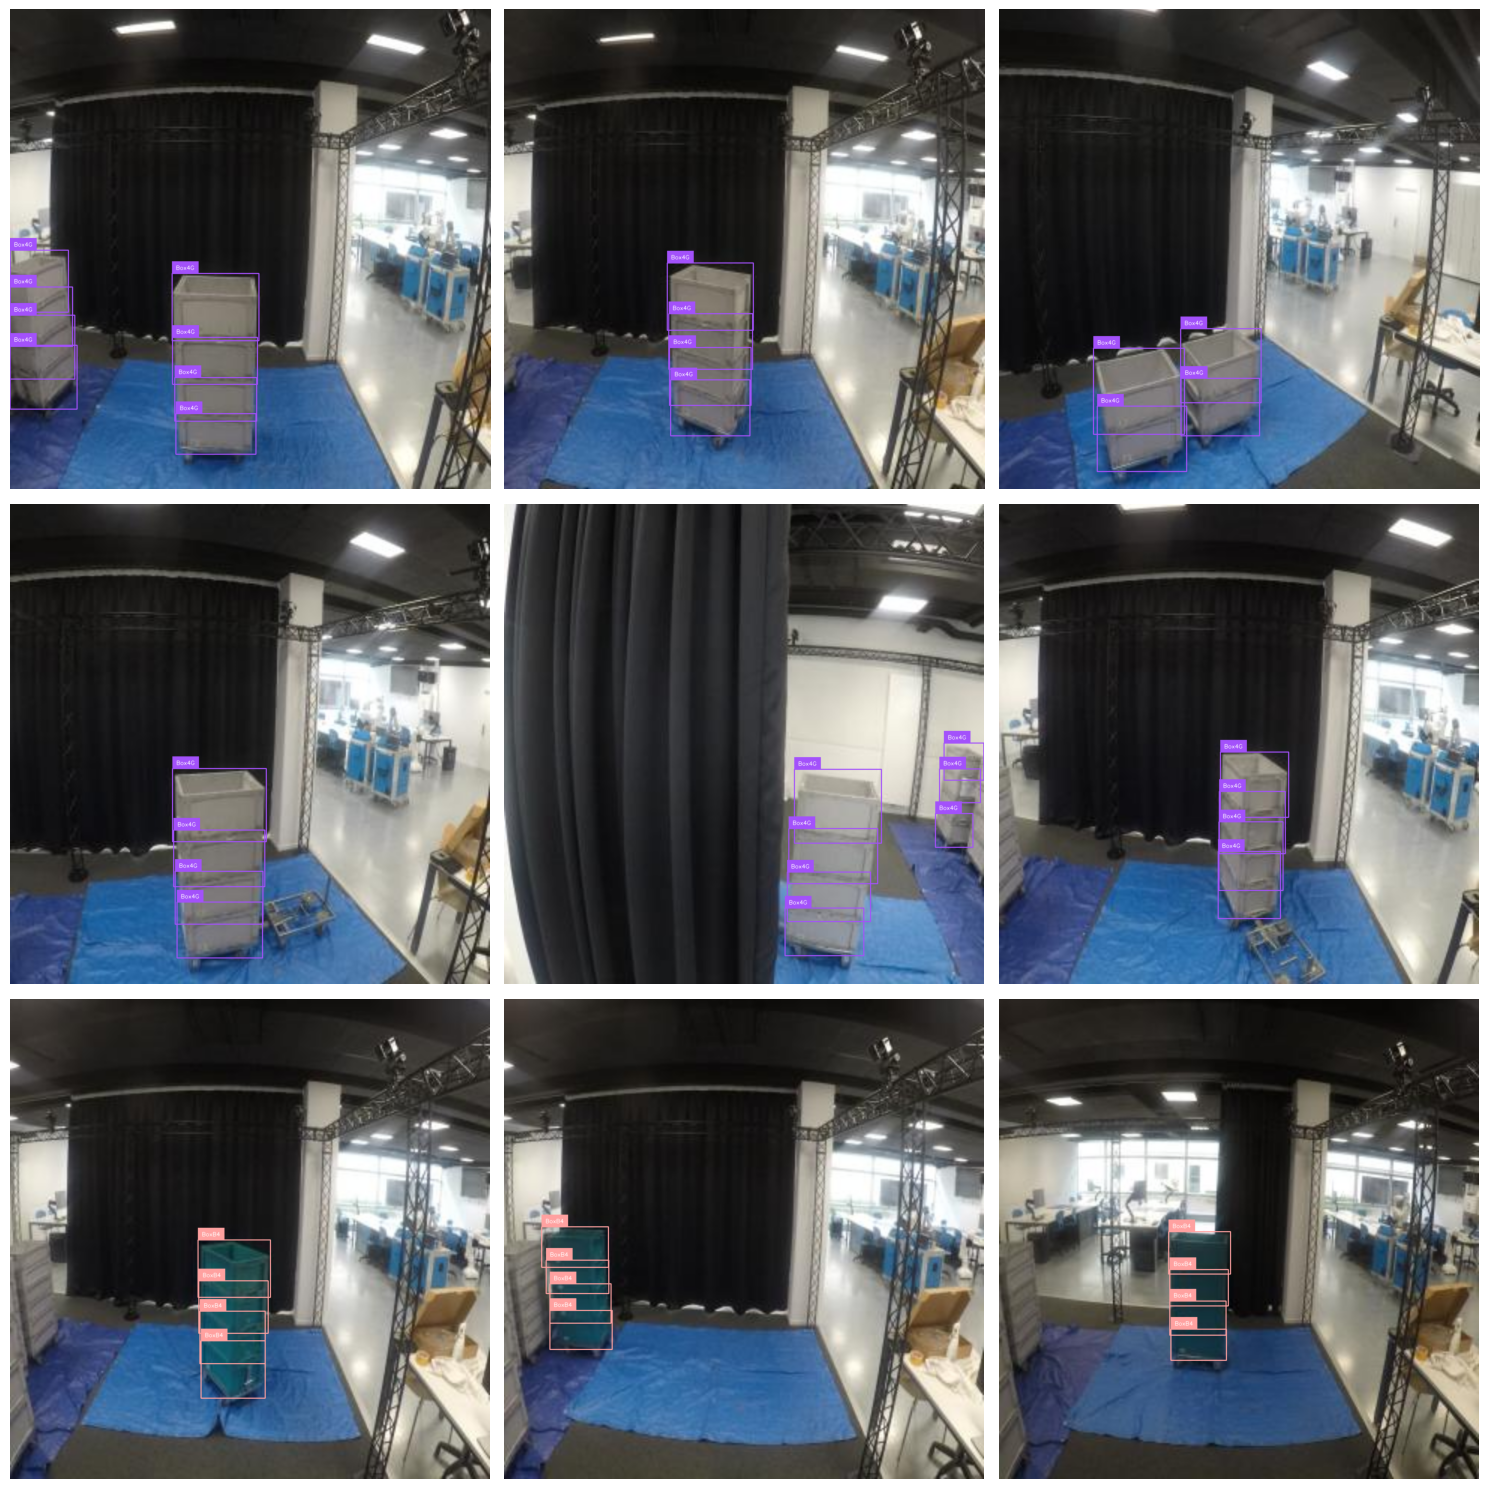

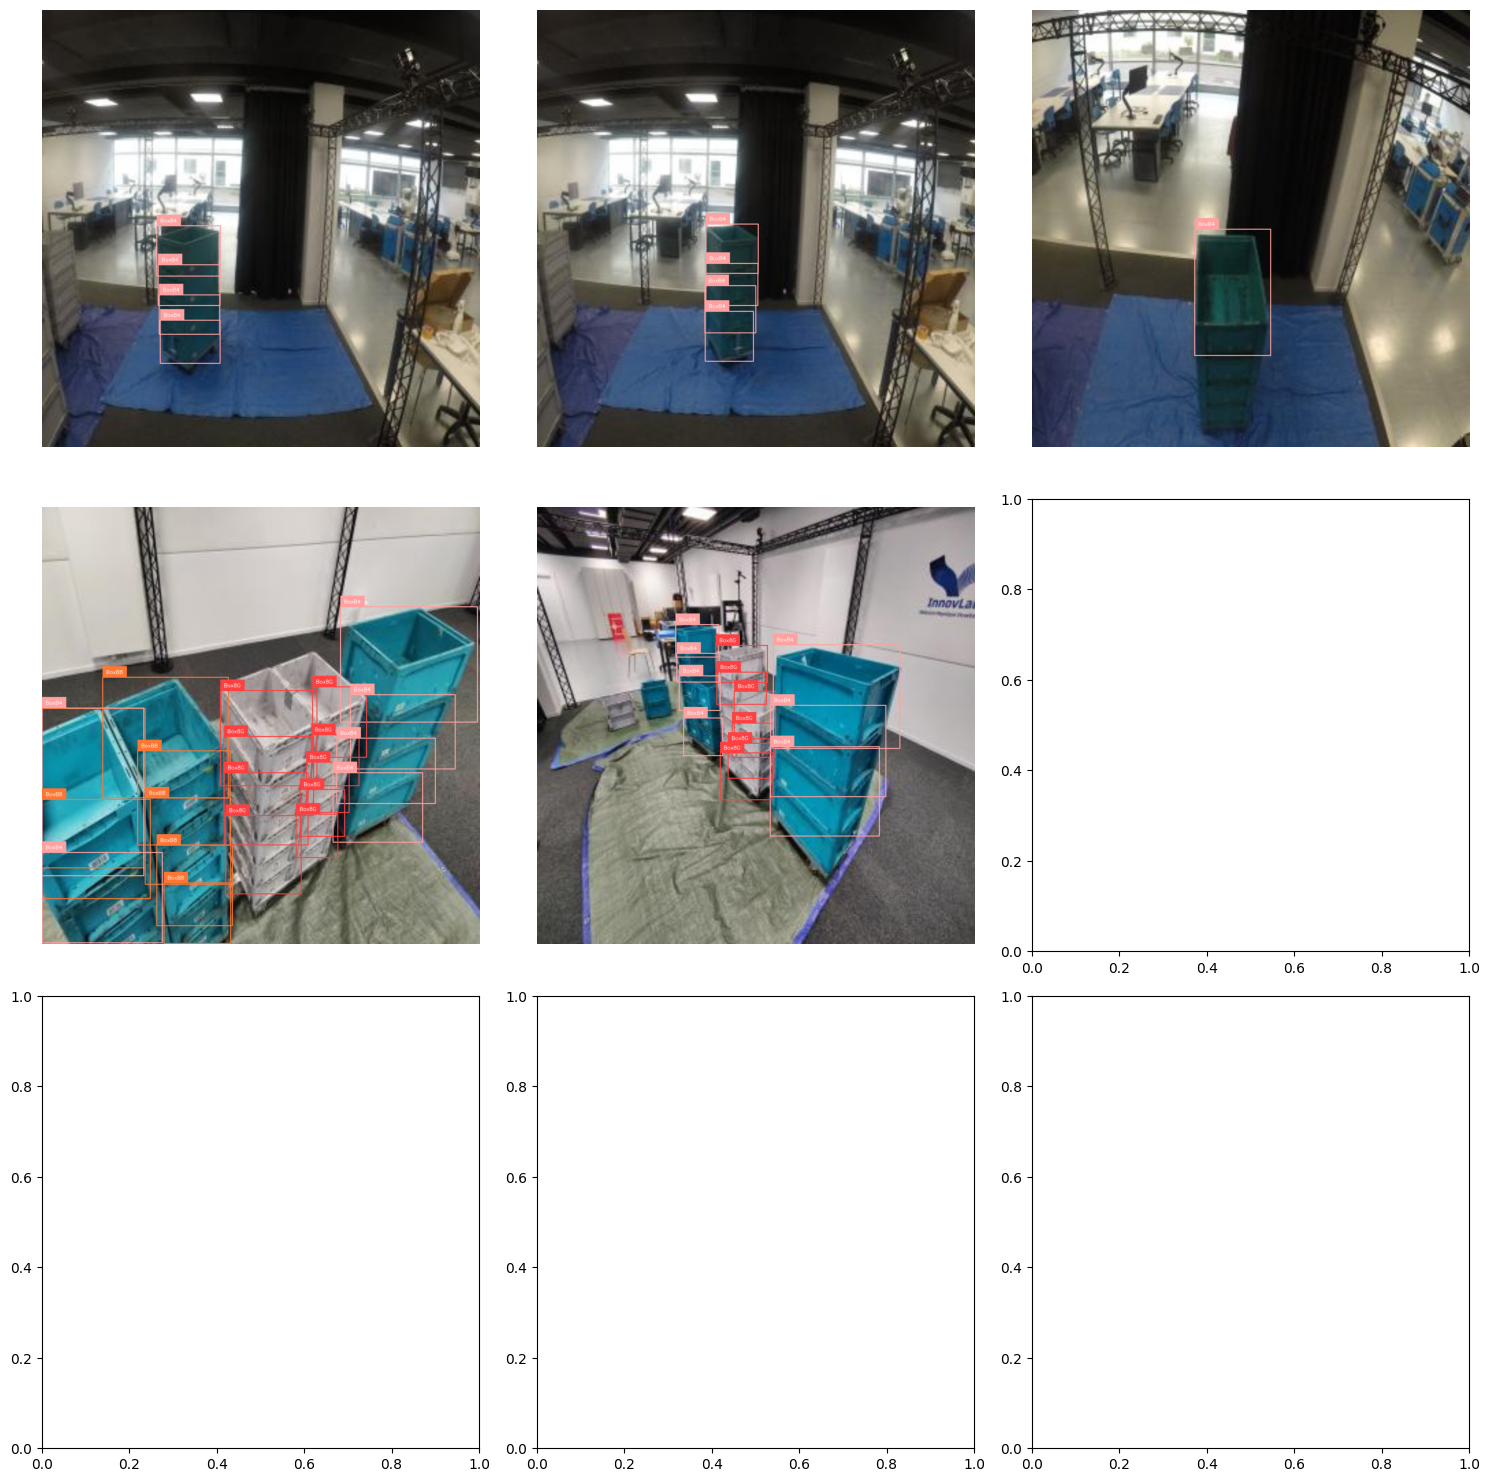

In [3]:
import glob
import cv2
import supervision as sv
import matplotlib.pyplot as plt
import math

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

image_paths = glob.glob(f"{path}/valid/images/*.jpg")
num_images = len(image_paths)

# Determine the number of grids
num_grids = math.ceil(num_images / 9)

# Iterate over each grid
for grid in range(num_grids):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid of subplots

    # Get the images for this grid
    grid_image_paths = image_paths[grid * 9 : (grid + 1) * 9]

    for ax, image_path in zip(axs.flatten(), grid_image_paths):
        image = cv2.imread(image_path)
        image = cv2.resize(image, (1280, 1280))
        results = model.predict(image, verbose=False, iou=0.4, conf=0.3)[0]
        detections = sv.Detections.from_ultralytics(results)
        labels = [model.model.names[class_id] for class_id in detections.class_id]
        annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
        ax.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Video rendering

## Used to generate annotated video from model and video.

When the model is not fast enough to run in real-time, it can be useful to generate a video with the model's predictions.
Showing its strength and weaknesses in a more visual way.


In [6]:
import supervision as sv
import cv2
import os
from tqdm import tqdm


def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames


def save_video(output_video_frames, output_video_path):
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    out = cv2.VideoWriter(output_video_path, fourcc, 24, (output_video_frames[0].shape[1], output_video_frames[0].shape[0]))
    for frame in output_video_frames:
        out.write(frame)
    out.release()


bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()


def render_video(video_path, output_video_path):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"File {video_path} does not exist")
    frames = read_video(video_path)
    output_video_frames = []
    for frame in tqdm(frames, desc="Processing frames"):
        frame = cv2.resize(frame, (1280, 1280))
        results = model(frame, iou=0.4, conf=0.3)[0]
        detections = sv.Detections.from_ultralytics(results)
        labels = [model.model.names[class_id] for class_id in detections.class_id]
        annotated_frame = bounding_box_annotator.annotate(scene=frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
        output_video_frames.append(annotated_frame)
    save_video(output_video_frames, output_video_path)


In [7]:
video_path = "../data/videos/innovlab_arround_rolls.mp4"
output_video_path = "output.mp4"
render_video(video_path, output_video_path)


KeyboardInterrupt: 